In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",StringType(),True), \
        StructField("FINAL_CAR_KEY",StringType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/06 12:44:50 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.61 instead (on interface eth0)
22/02/06 12:44:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/06 12:44:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# df = spark.read.csv('Sample_Traffic.csv',header=True,schema=schema)
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



# SVD

In [4]:
DATA_COUNT = df.count()
CAR_COUNT = df.select('FINAL_CAR_KEY').distinct().count()
CAMERA_COUNT = df.select('DEVICE_CODE').distinct().count()
print('all count: ', DATA_COUNT)
print('car count: ', CAR_COUNT)
print('camera count: ', CAMERA_COUNT)

all count:  4910236
car count:  1520404
camera count:  993


In [5]:
car_counts = df.groupBy('FINAL_CAR_KEY').count()
car_counts.sort('count', ascending=False).show(10)

+-------------+------+
|FINAL_CAR_KEY| count|
+-------------+------+
|     64111706|398901|
|     69177480|  9976|
|      8073331|  3121|
|     28621897|   509|
|     21683458|   311|
|      7633319|   308|
|      9093773|   305|
|      7736465|   234|
|     27397278|   167|
|      8396536|   166|
+-------------+------+
only showing top 10 rows



In [6]:
# traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(103)[3:]
traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(100)
traffic_cars = [x.FINAL_CAR_KEY for x in traffic_cars]
top_cars_df = df.filter(df.FINAL_CAR_KEY.isin(traffic_cars))
top_cars_df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|        100|       81|       22810018|     22810018|               5|       161|2021-06-01 04:10:54|
|     631763|       81|        7633319|      7633319|               5|       161|2021-06-01 02:28:23|
|     206602|       81|        8614075|      8614075|               5|       161|2021-06-01 02:24:01|
|     101301|       81|        7713151|      7713151|               5|       161|2021-06-01 01:57:46|
|     202101|       81|        7713151|      7713151|               5|       161|2021-06-01 02:21:58|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



In [7]:
TOP_CARS_COUNT = top_cars_df.count()
TOP_CARS_COUNT

7996

In [8]:
camera_car_df = top_cars_df.groupBy('DEVICE_CODE', 'FINAL_CAR_KEY').count()
camera_car_df.show(5)

+-----------+-------------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|count|
+-----------+-------------+-----+
|        135|     11086409|    1|
|     213301|     25826200|    1|
|        144|      8556436|    2|
|     202601|      8137760|    2|
|   22010087|      7633319|    7|
+-----------+-------------+-----+
only showing top 5 rows



In [9]:
from pyspark.ml.feature import StringIndexer

camera_car_indexed_df = StringIndexer(inputCol='FINAL_CAR_KEY', outputCol='CAR_INDEX').fit(camera_car_df).transform(camera_car_df)
camera_car_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='CAMERA_INDEX').fit(camera_car_indexed_df).transform(camera_car_indexed_df)

camera_car_indexed_df.show(5)
 

+-----------+-------------+-----+---------+------------+
|DEVICE_CODE|FINAL_CAR_KEY|count|CAR_INDEX|CAMERA_INDEX|
+-----------+-------------+-----+---------+------------+
|        135|     11086409|    1|      3.0|       139.0|
|     213301|     25826200|    1|      6.0|       226.0|
|        144|      8556436|    2|     40.0|        90.0|
|     202601|      8137760|    2|     37.0|        45.0|
|   22010087|      7633319|    7|      0.0|       234.0|
+-----------+-------------+-----+---------+------------+
only showing top 5 rows



In [10]:
camera_car_df.select('DEVICE_CODE').distinct().count()

331

In [11]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(camera_car_indexed_df.rdd.map(lambda x: (int(x['CAR_INDEX']), int(x['CAMERA_INDEX']), x['count']) ))

In [15]:
svd = utility_matrix.toRowMatrix().computeSVD(100, computeU=True)
print(svd.s)

22/02/06 08:58:56 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.


[505.0079430191521,448.4295807359056,234.00214006863334,179.1701725920204,164.08997913184254,128.8791269976936,89.96735321905756,85.39518265895747,81.27830846566535,73.68298955156429,71.16152478824884,63.00000000000001,54.67770373301821,50.08082000595019,46.65059215674066,40.75131283041665,39.49700737544456,38.81535112797081,37.883517887572744,37.477208085831876,36.48712513043299,34.10351087756282,32.95191581964757,31.668219074999598,29.382353059741757,28.007321050538476,27.81619066292238,27.173428229890284,25.9063839257756,25.51413614576888,24.916241572216165,24.226667981846077,24.030657094981326,23.365738603258077,19.73522502525707,18.44050839391655,17.983228407353685,17.882637049599147,17.512933811166867,16.650162052423365,16.219922944230152,15.917728847396386,15.32284427560125,14.385998218746812,13.55772093864274,12.77531198470423,12.033550152122068,11.946000054777999,11.341697289372854,11.021451077725494,10.16109555211842,9.735261830759898,9.507578905362777,9.188825793668242,8.823

22/02/06 08:59:06 WARN RowMatrix: Requested 100 singular values but only found 98 nonzeros.
22/02/06 08:59:06 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [13]:
print(utility_matrix.numCols())
print(utility_matrix.numRows())

331
100


In [ ]:
# rdd = df.rdd.map(lambda x: ((x['FINAL_CAR_KEY'], x['PASS_DAY_TIME'].date()),  x['DEVICE_CODE']))
# rdd.take(5)

# Clustering

In [22]:
# df.show(2)
df.summary().show()

+-------+--------------------+------------------+--------------------+-------------------+------------------+------------------+
|summary|         DEVICE_CODE|         SYSTEM_ID|     ORIGINE_CAR_KEY|      FINAL_CAR_KEY|  CHECK_STATUS_KEY|        COMPANY_ID|
+-------+--------------------+------------------+--------------------+-------------------+------------------+------------------+
|  count|            34989160|          34989160|            34989160|           34989159|          34989159|          34989160|
|   mean|2.2262293326161418E7|236.54757084765683|3.6067905310963854E7|3.702608833010948E7|5.2871780656402745|218.93599797765935|
| stddev| 3.741603259148462E7| 84.44216726147245|3.1140705482597664E7|3.076635128051584E7|0.6188797307503013| 63.36385080523604|
|    min|                 100|                81|           100000013|          100000013|                 1|                 0|
|    25%|              900107|               282|           9713210.0|          9839529.0|       

In [7]:
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
# row1 = spark.createDataFrame(df.take(2), schema)
# row2 = spark.createDataFrame([(1,2,3,4,5,6,datetime.datetime.now())], schema)
# appended = row1.union(row2)
# appended.show()
# appended.withColumn('weekday', dayofweek(appended.PASS_DAY_TIME)).show()


df_with_time_columns = df.withColumn('weekday', dayofweek(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.withColumn('hour', hour(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.select('DEVICE_CODE', 'FINAL_CAR_KEY', 'weekday', 'hour')
df_with_time_columns.show(5)
#  df.withColumn('weekday', dayofweek(df.PASS_DAY_TIME)).select('weekday').distinct().count()



+-----------+-------------+-------+----+
|DEVICE_CODE|FINAL_CAR_KEY|weekday|hour|
+-----------+-------------+-------+----+
|     200501|     10477885|      3|   3|
|        155|     87625017|      3|   4|
|     631757|      8652928|      3|   3|
|     631757|      8548123|      3|   4|
|     631757|     24715264|      3|   3|
+-----------+-------------+-------+----+
only showing top 5 rows



In [8]:
camera_daily_df = df_with_time_columns.groupBy(
    'DEVICE_CODE',
    'weekday',
    'hour'
).count()
camera_daily_df.show(5)

+-----------+-------+----+-----+
|DEVICE_CODE|weekday|hour|count|
+-----------+-------+----+-----+
|     631763|      3|   1|  178|
|        125|      3|   0|    1|
|        169|      3|   6|  396|
|     631776|      3|   4|   15|
|     900222|      3|   0|  533|
+-----------+-------+----+-----+
only showing top 5 rows



In [9]:
from pyspark.ml.feature import StringIndexer

camera_daily_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(camera_daily_df).transform(camera_daily_df)
camera_daily_indexed_df.show(5)

+-----------+-------+----+-----+------+
|DEVICE_CODE|weekday|hour|count|camera|
+-----------+-------+----+-----+------+
|     631763|      3|   1|  178| 667.0|
|        125|      3|   0|    1| 600.0|
|        169|      3|   6|  396|  78.0|
|     631776|      3|   4|   15| 513.0|
|     900222|      3|   0|  533| 230.0|
+-----------+-------+----+-----+------+
only showing top 5 rows



In [ ]:
# from pyspark.mllib.linalg.distributed import CoordinateMatrix

# camera_traffic_matrix = CoordinateMatrix(camera_daily_indexed_df.rdd.map(lambda x: (
#     int(x['camera']), 
#     (x['weekday']-1)*24 + x['hour'],
#     x['count'] 
#     )))


# camera_traffic_matrix.toRowMatrix().rows.take(1)

# from pyspark.mllib.clustering import LDA

# lda_model = LDA.train(camera_traffic_matrix.toRowMatrix().rows.map(lambda x: 
# (1, x)
# ), k = 2)
# topics = lda_model.topicsMatrix()
# topics

In [10]:
def convert_to_vector(x):
    camera = x[0]
    daily_list = x[1]
    vector = [0]*24*7
    for y in daily_list:
        index = y[0]
        count = y[1]
        vector[index] = count

    return (camera, vector)



camera_vectors = camera_daily_df.rdd.map(lambda x: 
    (
    x['DEVICE_CODE'], 
    (
        (x['weekday']-1)*24 + x['hour'],
         x['count']
    )
    )
).groupByKey().mapValues(list).map(convert_to_vector)

camera_vectors.cache()
camera_vectors.take(5)

[(631776,
  [54,
   17,
   11,
   12,
   10,
   11,
   21,
   48,
   70,
   93,
   125,
   159,
   187,
   158,
   112,
   74,
   104,
   170,
   223,
   241,
   251,
   226,
   56,
   0,
   0,
   9,
   11,
   7,
   10,
   23,
   66,
   166,
   185,
   157,
   179,
   160,
   148,
   140,
   149,
   196,
   341,
   483,
   594,
   452,
   315,
   182,
   83,
   45,
   55,
   33,
   18,
   14,
   15,
   38,
   124,
   352,
   311,
   285,
   401,
   378,
   370,
   288,
   339,
   396,
   777,
   1127,
   1134,
   1024,
   647,
   465,
   155,
   94,
   23,
   19,
   6,
   12,
   6,
   30,
   64,
   167,
   141,
   151,
   189,
   194,
   165,
   146,
   173,
   189,
   333,
   489,
   564,
   467,
   348,
   238,
   87,
   57,
   28,
   23,
   11,
   7,
   12,
   17,
   44,
   101,
   125,
   133,
   165,
   148,
   232,
   380,
   281,
   143,
   152,
   101,
   243,
   232,
   223,
   233,
   92,
   67,
   56,
   34,
   18,
   25,
   16,
   13,
   24,
   43,
   70,
   97,
   127,
   

In [17]:
from pyspark.mllib.clustering import LDA
from pyspark.mllib.linalg import Vectors
cluster_count = 5
lda_model = LDA.train(camera_vectors.map(lambda x: [x[0], Vectors.dense(x[1])]), k = cluster_count)
topics = lda_model.topicsMatrix()
topics

array([[ 11090.91019724,   9764.26997568,  13151.93952669,
         14826.24836443,  16736.63193596],
       [  7158.89999318,   5477.69478097,   8142.39051539,
         11957.32326952,  11844.69144094],
       [  4322.21973057,   3318.64169407,   4719.78599584,
          6875.25507441,   6202.09750511],
       [  4302.53762946,   3252.04260991,   4632.68692058,
          6517.48999924,   6051.24284082],
       [  2916.98352621,   2591.95446565,   3415.35589154,
          4950.51519628,   4689.19092032],
       [  4670.3907073 ,   3755.18619115,   5944.32385963,
          5535.57125147,   7512.52799045],
       [ 11571.90352903,   9585.59422545,  13640.99346677,
          8729.81388737,  18417.69489138],
       [ 15355.50303927,  16439.92950564,  21320.47436462,
         13337.17056158,  25267.92252889],
       [ 19251.18219788,  16409.99356358,  24511.95577776,
         14444.83661159,  37833.0318492 ],
       [ 22676.69490979,  18891.18694107,  32261.55832091,
         19013.87910932

Learned topics (as distributions over vocab of 168 words):


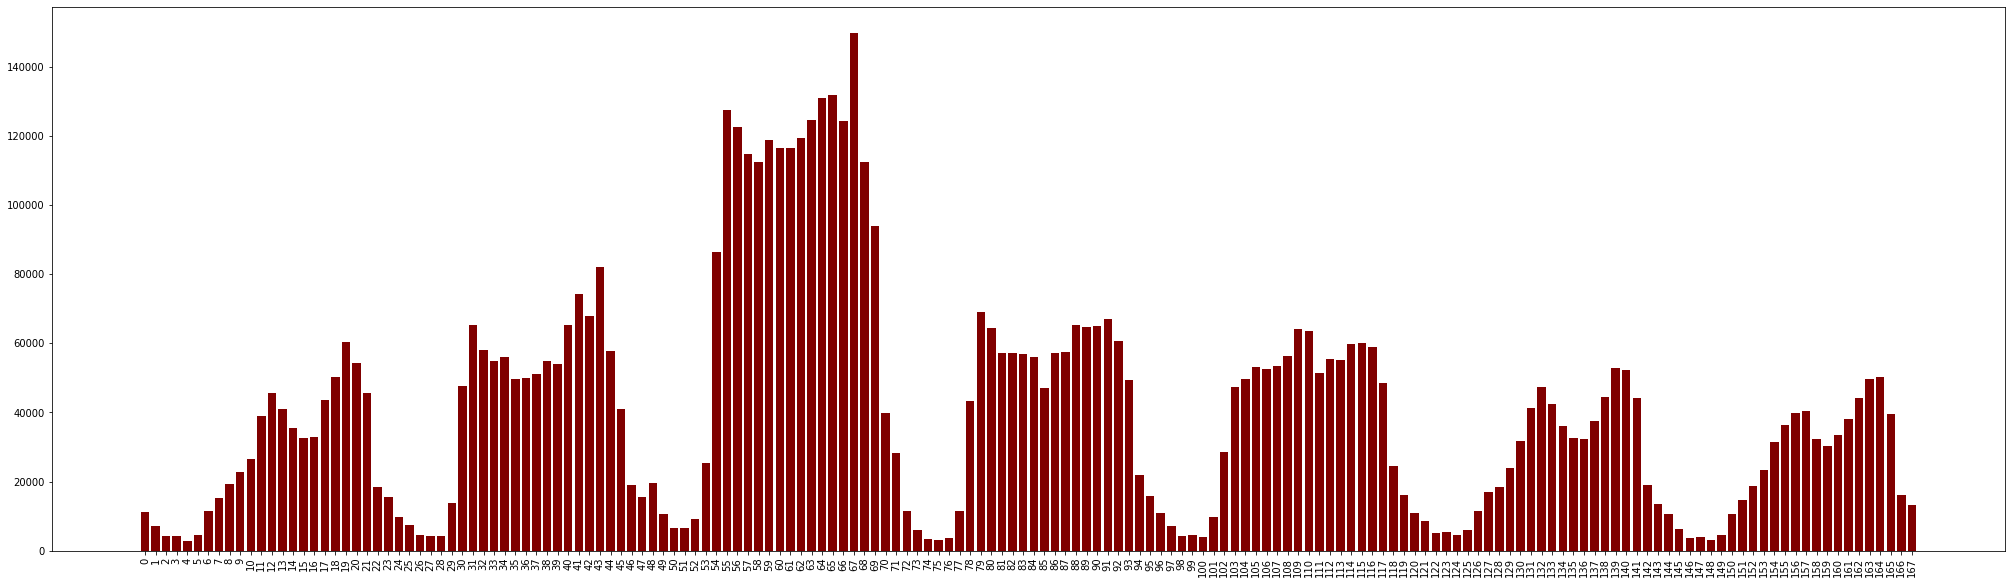

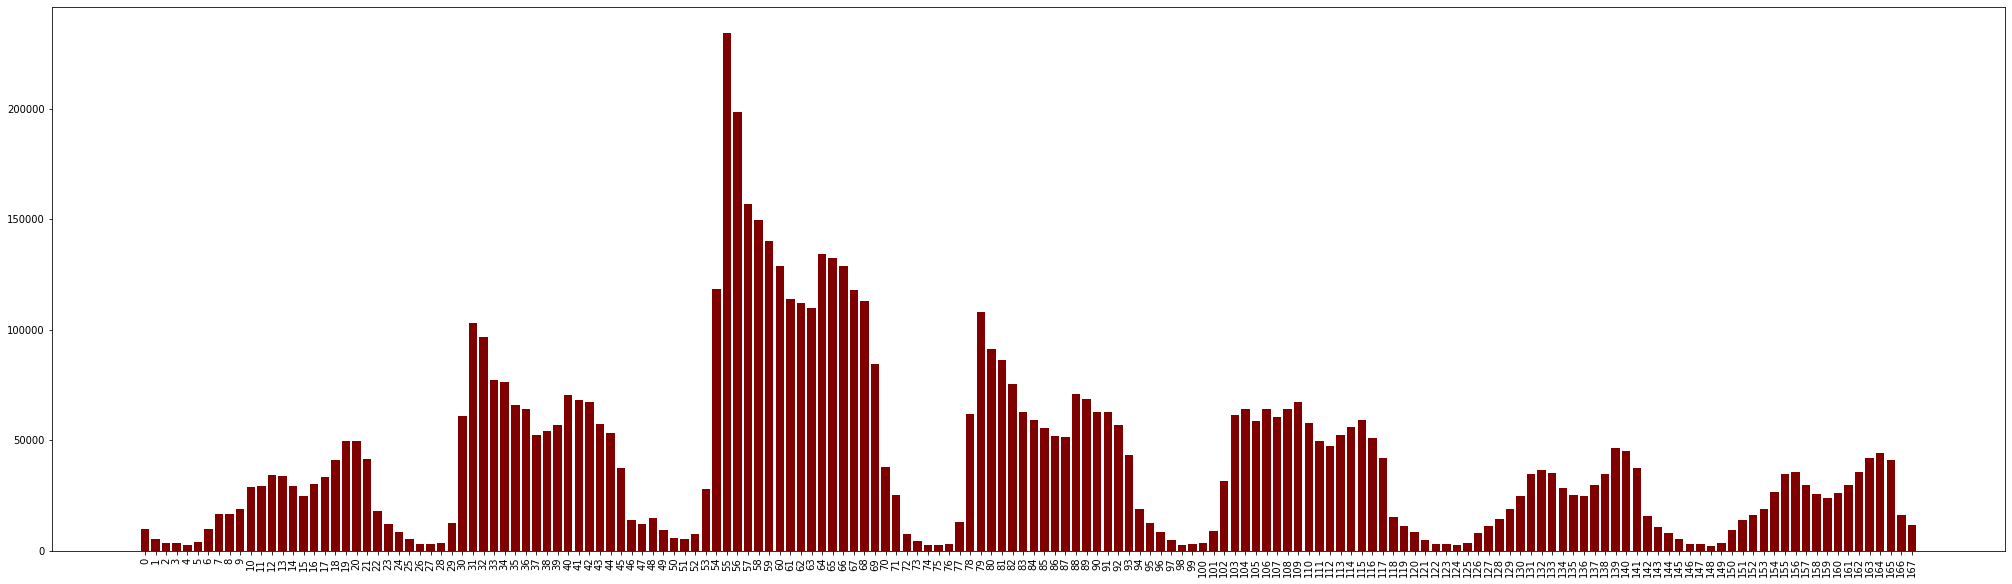

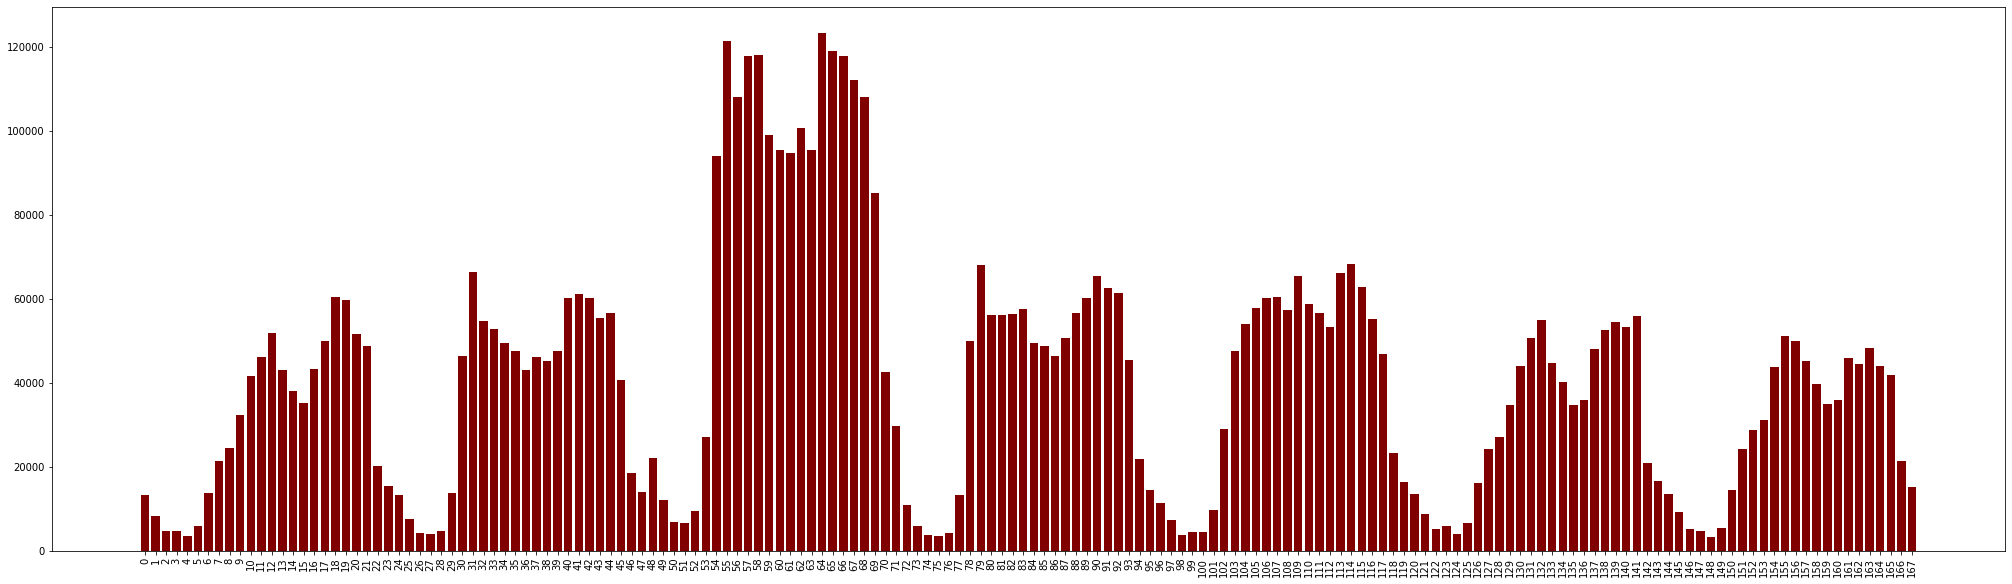

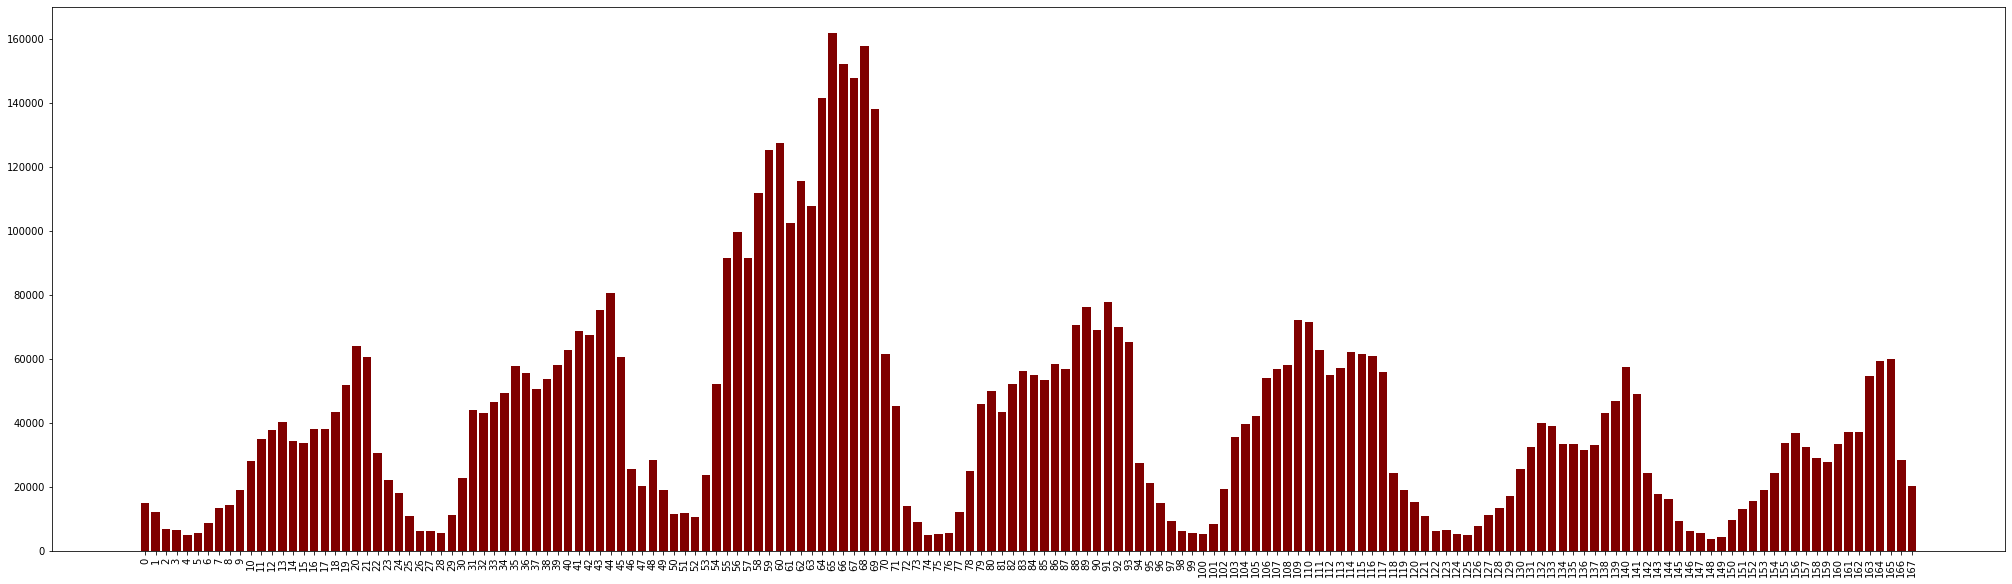

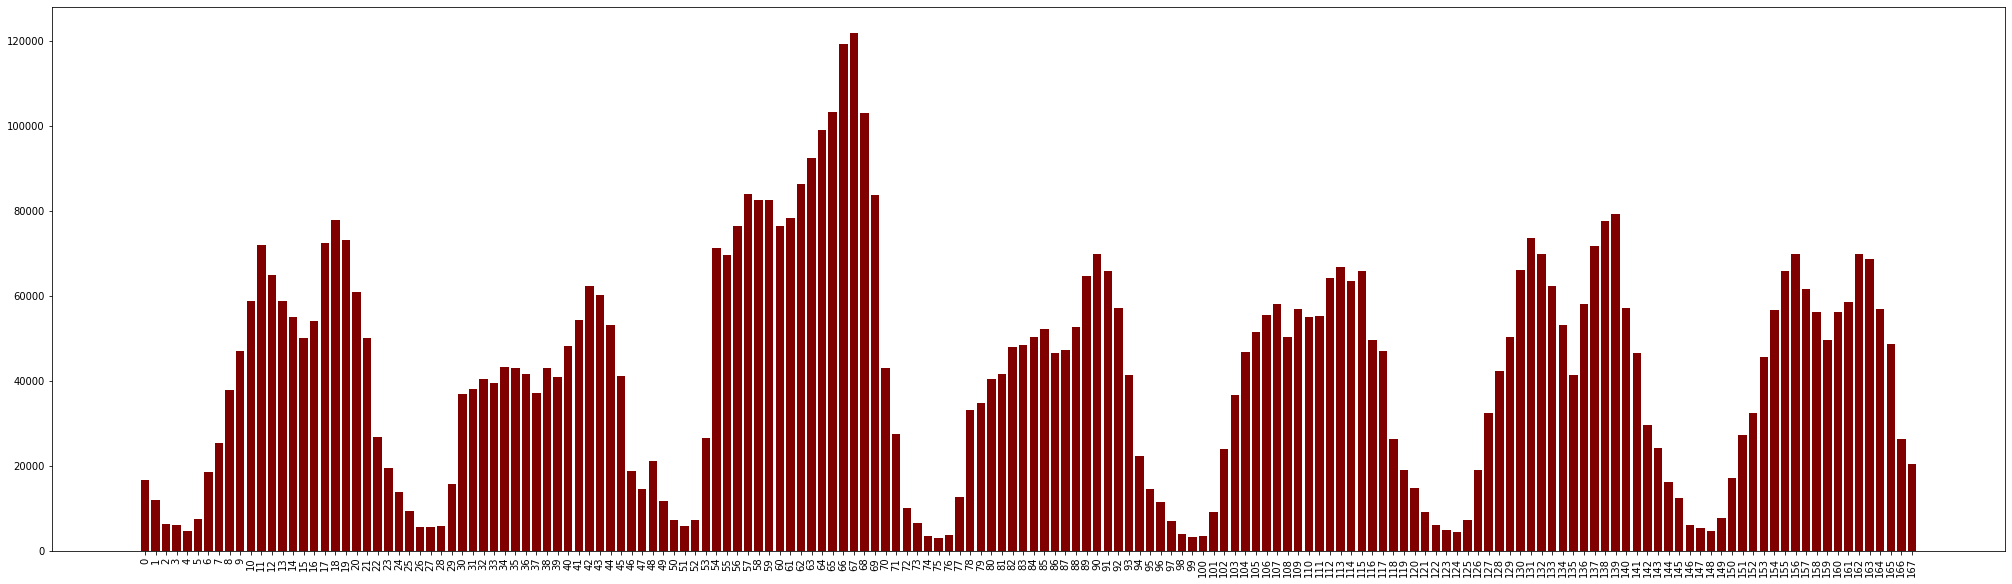

In [18]:
import matplotlib.pyplot as plt
print("Learned topics (as distributions over vocab of " + str(lda_model.vocabSize())
      + " words):")
for topic in range(cluster_count):
      fig = plt.figure(figsize = (35, 10))
      # print(len(lable_list))
      # print(len(topics[:,topic]))
      label_list = list(map(lambda x: str(x), range(24*7)))
      plt.bar(label_list,topics[:,topic], color ='maroon',
      width = 0.8)
      plt.xticks(rotation='vertical',fontsize=10)
      plt.show()